1. Loading the data

In [1]:
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt")
filepath = "the-verdict.txt"

urllib.request.urlretrieve(url, filepath)

('the-verdict.txt', <http.client.HTTPMessage at 0x7f930d6434c0>)

In [2]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print(f"Total number of characters: {len(raw_text)}")
print(raw_text[:500])

Total number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


2. Preprocessing - tokenization

In [3]:
import re

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))
print(preprocessed[:30])

4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


3. Creating vocab

In [4]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
print(f"Vocabulary size: {len(all_tokens)}")

Vocabulary size: 1132


In [5]:
vocab = {token:integer for integer, token in enumerate(all_tokens)}
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)



('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


4. Simple tokenizer

In [6]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]

        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
            

        ids = [self.str_to_int[word] for word in preprocessed]

        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text
    

tokenizer = SimpleTokenizerV2(vocab=vocab)

text = """
        "It's the last he painted, you know, "
        Mrs. Gisburn said with pardonable pride."""

ids = tokenizer.encode(text)
print(ids)
print(tokenizer.decode(ids))

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [7]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)
ids = tokenizer.encode(text)
print(ids)
print(tokenizer.decode(ids))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


5. Byte pair encoding


In [8]:
from importlib.metadata import version
import tiktoken

print(f"tiktoken version: {version('tiktoken')}")

tiktoken version: 0.8.0


In [9]:
tokenizer = tiktoken.get_encoding("gpt2")   # TODO: implement own tokenizer
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})    # Vocabulary size GPT2: 50257
print(integers)
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 262, 20562, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [10]:
test_text = "Ekretss ddddxxx thae je"
integers = tokenizer.encode(test_text)
print(integers)
strings = tokenizer.decode(integers)
print(strings)

[36, 74, 1186, 824, 288, 1860, 67, 31811, 294, 3609, 11223]
Ekretss ddddxxx thae je


6. DataLoader

In [11]:
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))
enc_sample = enc_text[50:]

5145


In [12]:
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x:    {x}")
print(f"y:         {y}")

x:    [290, 4920, 2241, 287]
y:         [4920, 2241, 287, 257]


In [13]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [14]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [15]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu124
True


In [16]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_lenght, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids)- max_lenght, stride):
            input_chunk = token_ids[i:i + max_lenght]
            target_chunk = token_ids[i + 1: i + max_lenght + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [17]:
def create_dataloader_v1(txt, batch_size=4, max_lenght=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_lenght, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,    # Drop last batch if it is shorter than the specified batch_size to prevent loss spikes during training
        num_workers=num_workers
    )

    return dataloader

In [18]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_lenght=4, stride=4, shuffle=False
)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)
# second_batch = next(data_iter)
# print(second_batch)

[tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]]), tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])]


7. Token embeddings

In [19]:
input_ids = torch.tensor([2,3,5,1])
vocab_size = 6
output_dim = 3

In [20]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)    # Better than one-hot encoding - more efficient way of matrix multiplication in fully connecterd layer
print(embedding_layer.weight)   # Initiated embedding layer with weights

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [21]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [22]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


8. Positional token embeddings

In [23]:
# Position-independent embedding of tokens are better for reproducibility purposes.
# However self-attention mechanism is also positio-agnostic (meaning it treats all tokens in a sequence equally regardless of their order)
# it is helpful to injest positional information into the LLM

vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [24]:
max_lenght = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_lenght=max_lenght, stride=max_lenght, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token ID: \n", inputs)
print("\nInput shape: \n", inputs.shape)    # first batch consists of 8 text examples, 4 tokens each

Token ID: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Input shape: 
 torch.Size([8, 4])


In [25]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# 8 - examples
# 4 - tokens for each example
# 256 - embedding values for each token

torch.Size([8, 4, 256])


In [26]:
# To add absolute embedding approach we add another layer of embeddings

context_lenght = max_lenght
pos_embedding_layer = torch.nn.Embedding(context_lenght, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_lenght))
print(pos_embeddings.shape)

# 4 - tokens in example
# 256 - values of pos embeddings


torch.Size([4, 256])


In [27]:
# we just add that two embedding layers
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

# When adding positional embeddings to token embeddings, PyTorch automatically broadcasts the positional embeddings across the batch dimension. 
# Broadcasting expands the positional embeddings from 4×256 to 8×4×256 to match the shape of the token embeddings.
# Duplicating positional embeddings for each batch example would be redundant and inefficient in terms of memory.

torch.Size([8, 4, 256])


9. Simple self attention mechanism without trainable weights

In [28]:
inputs = torch.tensor(
    [
        [0.43, 0.15, 0.89], # Your
        [0.55, 0.87, 0.66], # journey
        [0.57, 0.85, 0.64], # starts
        [0.22, 0.58, 0.33], # with
        [0.77, 0.25, 0.10], # one
        [0.05, 0.80, 0.55], # step

    ]
)

In [29]:
# 1. Multiplying input token with all tokens in a sequence -> it gives us floats
query = inputs[1] # attention scores for word 'journey'
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)    # concise way of multiplying two vectors. It is a measure of similarity of one word to each words in a sequence
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [30]:
# torch.dot(x_i, query) is essentially the same as:
res = 0

for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]

print(res)

tensor(0.9544)


In [31]:
# 2. Normalize the results
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()    # we normalize but it is advisable to do that with softmax function
print(f"Attention weights normalized: {attn_weights_2_tmp}")
print(f"Sum: {attn_weights_2_tmp.sum()}")

Attention weights normalized: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: 1.0000001192092896


In [32]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)   # softmax function assures that we don't get negative values. 
                                                    # this apprach however can have underflow or overflow. Therefore we use build in torch.softmax
attn_weights_2_naive = softmax_naive(attn_scores_2)
print(f"Attention scores naive: {attn_weights_2_naive}")
print(f"Sum: {attn_weights_2_naive.sum()}")

Attention scores naive: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: 1.0


In [33]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print(f"Attention scores torch.softmax: {attn_weights_2}")
print(f"Sum: {attn_weights_2.sum()}")

Attention scores torch.softmax: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: 1.0


In [34]:
# 3. Now we can calculate context vector by multiplying each token vector values with corresponding attention weights 
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


In [35]:
# To do that for all:
# 1. Compute attention scores
# 2. Compute attention weights
# 3. Compute context vectors

attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [36]:
# More efficeint way is to use matrix multiplications:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [37]:
# We normalize
attn_weights = torch.softmax(attn_scores, dim=-1) # dim=-1 means we want to apply the softmax along the last dimension of attn_scores tensor
print(attn_weights)

# dim=-1: This is commonly used for normalizing attention scores so that each query focuses on different keys with probabilities summing to 1.
# dim=-2: This is less common but could be used in scenarios where you want to normalize attention scores across queries.


tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [38]:
row_2_sum = attn_weights[1].sum()
print(f"Row 2 sum: {row_2_sum}")
print(f"All rows sums across columns: {attn_weights.sum(dim=-1)}")

Row 2 sum: 1.0
All rows sums across columns: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [39]:
# Now we calculate context vector
all_context_vecs = attn_weights @ inputs
all_context_vecs


tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [40]:
all_context_vecs[1] # same as context_vec_2

tensor([0.4419, 0.6515, 0.5683])

10. Self attention mechanism with trainable weights - scaled dot-product attention

In [41]:
# Introduction of Wq Wk Wv matrices
x_2 = inputs[1]
d_in = inputs.shape[1]  # input embedding size 3
d_out = 2               # output embedding size 2   # it is usually better to use same dims but for sake of learning the computations I leave 2

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

keys = inputs @ W_key
values = inputs @ W_value
query_2= x_2 @ W_query
print(query_2)

tensor([0.4306, 1.4551])


In [42]:
keys_2 = keys[1]
attn_scores_2 = query_2.dot(keys_2) # only for second token
attn_scores_2

tensor(1.8524)

In [43]:
attn_scores = query_2 @ keys.T    # all attention scores for second token
attn_scores

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])

In [44]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores / d_k**0.5, dim=-1)
attn_weights_2

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])

In [45]:
context_vectos_2 = attn_weights_2 @ values
context_vectos_2

tensor([0.3061, 0.8210])

In [46]:
from self_attention import SelfAttention_V1, SelfAttention_V2, SelfAttention_V1_with_V2_weights
torch.manual_seed(123)
sa_v1 = SelfAttention_V1(d_in, d_out)
sa_v1(inputs)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)

In [47]:
sa_v2 = SelfAttention_V2(d_in, d_out)
torch.manual_seed(789)
sa_v2(inputs)

tensor([[0.5085, 0.3508],
        [0.5084, 0.3508],
        [0.5084, 0.3506],
        [0.5074, 0.3471],
        [0.5076, 0.3446],
        [0.5077, 0.3493]], grad_fn=<MmBackward0>)

In [48]:
torch.manual_seed(789)
sa_v12 = SelfAttention_V1_with_V2_weights(d_in, d_out)
sa_v12(inputs)

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

11. Masking future words

In [49]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1362, 0.1730, 0.1736, 0.1713, 0.1792, 0.1666],
        [0.1359, 0.1730, 0.1735, 0.1716, 0.1790, 0.1670],
        [0.1366, 0.1729, 0.1734, 0.1714, 0.1788, 0.1669],
        [0.1493, 0.1701, 0.1704, 0.1697, 0.1732, 0.1674],
        [0.1589, 0.1690, 0.1692, 0.1667, 0.1712, 0.1649],
        [0.1408, 0.1715, 0.1718, 0.1717, 0.1758, 0.1684]],
       grad_fn=<SoftmaxBackward0>)


In [50]:
context_lenght = attn_scores.shape[0]   # 6
mask_simple = torch.tril(torch.ones(context_lenght, context_lenght))
mask_simple

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

In [51]:
masked_simple = attn_weights * mask_simple
masked_simple

tensor([[0.1362, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1359, 0.1730, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1366, 0.1729, 0.1734, 0.0000, 0.0000, 0.0000],
        [0.1493, 0.1701, 0.1704, 0.1697, 0.0000, 0.0000],
        [0.1589, 0.1690, 0.1692, 0.1667, 0.1712, 0.0000],
        [0.1408, 0.1715, 0.1718, 0.1717, 0.1758, 0.1684]],
       grad_fn=<MulBackward0>)

In [52]:
rows_sum = masked_simple.sum(dim=-1, keepdim=True)  # i want to keep dimension like it is, not convert to list
masked_simple_normalized = masked_simple / rows_sum # there is no informatin leakage because softmax with values 0 is not considering those values
masked_simple_normalized

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4400, 0.5600, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2830, 0.3580, 0.3590, 0.0000, 0.0000, 0.0000],
        [0.2264, 0.2579, 0.2583, 0.2574, 0.0000, 0.0000],
        [0.1903, 0.2024, 0.2026, 0.1997, 0.2051, 0.0000],
        [0.1408, 0.1715, 0.1718, 0.1717, 0.1758, 0.1684]],
       grad_fn=<DivBackward0>)

In [53]:
# it is possible to do it more effectively by setting those values to -inf not to 0

mask = torch.triu(torch.ones(context_lenght, context_lenght), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
masked

tensor([[-0.2327,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.2396,  0.1015,    -inf,    -inf,    -inf,    -inf],
        [-0.2323,  0.1004,  0.1045,    -inf,    -inf,    -inf],
        [-0.1344,  0.0502,  0.0523,  0.0470,    -inf,    -inf],
        [-0.0349,  0.0520,  0.0538,  0.0331,  0.0708,    -inf],
        [-0.2142,  0.0650,  0.0679,  0.0668,  0.1004,  0.0395]],
       grad_fn=<MaskedFillBackward0>)

In [54]:
# now what is left it to normalize it
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4400, 0.5600, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2830, 0.3580, 0.3590, 0.0000, 0.0000, 0.0000],
        [0.2264, 0.2579, 0.2583, 0.2574, 0.0000, 0.0000],
        [0.1903, 0.2024, 0.2026, 0.1997, 0.2051, 0.0000],
        [0.1408, 0.1715, 0.1718, 0.1717, 0.1758, 0.1684]],
       grad_fn=<SoftmaxBackward0>)

12. Dropout to prevent overfitting

In [55]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # elements are scaled by 1 / 0.5 = 2 to compensate
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [56]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1200, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7181, 0.0000, 0.0000, 0.0000],
        [0.4528, 0.5159, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3806, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3430, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


13. Casual attention

In [57]:
batch = torch.stack((inputs, inputs), dim=0)
batch

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [58]:
batch.shape

torch.Size([2, 6, 3])

In [59]:
from self_attention import CasualAttention
torch.manual_seed(123)
context_lenght = batch.shape[1]
ca = CasualAttention(d_in, d_out, context_lenght, 0.0)
context_vecs = ca(batch)
print(f"context_vec shape: {context_vecs.shape}")

context_vec shape: torch.Size([2, 6, 2])


14. Multi head attention

In [60]:
from self_attention import MultiHeadAttentionWrapper
torch.manual_seed(123)
context_lenght = batch.shape[1]
d_in, d_out = 3, 2

mha = MultiHeadAttentionWrapper(d_in, d_out, 6, 0.0, 2)
context_vecs = mha(batch)
print(f"Shape of context_vecs: {context_vecs.shape}")
context_vecs

Shape of context_vecs: torch.Size([2, 6, 4])


tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)

In [61]:
a = torch.tensor(
    [
        [
            [
                [0.2745, 0.6584, 0.2775, 0.8573],
                [0.8993, 0.0390, 0.9268, 0.7388],
                [0.7179, 0.7058, 0.9156, 0.4340]
            ],
            [
                [0.0772, 0.3565, 0.1479, 0.5331],
                [0.4066, 0.2318, 0.4545, 0.9737],
                [0.4606, 0.5159, 0.4220, 0.5786]
            ]
        ]
    ]
)
a.shape


torch.Size([1, 2, 3, 4])

In [62]:
a @ a.transpose(2,3)

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])

In [63]:
first_head = a[0,0,:,:]
first_res = first_head @ first_head.T
first_res

tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

In [64]:
second_head = a[0,1,:,:]
second_res = second_head @ second_head.T
second_res

tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])

In [65]:
from self_attention import MultiHeadAttention
torch.manual_seed(123)
batch_size, context_lenght, d_in = batch.shape
d_out = 2

mha = MultiHeadAttention(d_in, d_out, context_lenght, 0.5, num_heads=2)
context_vec = mha(batch)
print(context_vec.shape)
context_vec

torch.Size([2, 6, 2])


tensor([[[0.2940, 0.7409],
         [0.3680, 0.3385],
         [0.2490, 0.4221],
         [0.2704, 0.2916],
         [0.2888, 0.3418],
         [0.2809, 0.3408]],

        [[0.1934, 0.6825],
         [0.1989, 0.6858],
         [0.3221, 0.2964],
         [0.2210, 0.4556],
         [0.2384, 0.4428],
         [0.2956, 0.3488]]], grad_fn=<ViewBackward0>)

16. All together

In [66]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)

batch


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [67]:
# from models import DummyGPTModel, GPT_CONFIG_124M

# torch.manual_seed(123)
# model = DummyGPTModel(GPT_CONFIG_124M)
# logits = model(batch)
# print(logits.shape)
# logits

In [68]:
# Layer normalization
import torch
import torch.nn as nn
from models import GPT_CONFIG_124M

torch.manual_seed(123)
batch_example = torch.rand(2, 5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())    # rectified linear unit
out = layer(batch_example)
out

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)

In [69]:
batch_example

tensor([[0.2961, 0.5166, 0.2517, 0.6886, 0.0740],
        [0.8665, 0.1366, 0.1025, 0.1841, 0.7264]])

In [70]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"Mean: \n{mean}")
print(f"STD: \n{var}")

Mean: 
tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
STD: 
tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [71]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
torch.set_printoptions(sci_mode=False)  # do not use scientific notation
print(f"Mean: \n{mean}")
print(f"STD: \n{var}")

Mean: 
tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
STD: 
tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [72]:
from models import LayerNorm

ln = LayerNorm(emb_dim=5)

out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
torch.set_printoptions(sci_mode=True)  # do not use scientific notation
print(f"Mean: \n{mean}")
print(f"STD: \n{var}")
out_ln

Mean: 
tensor([[ 2.3842e-08],
        [-9.5367e-08]], grad_fn=<MeanBackward1>)
STD: 
tensor([[9.9978e-01],
        [9.9991e-01]], grad_fn=<VarBackward0>)


tensor([[-3.2294e-01, 7.0492e-01, -5.3015e-01, 1.5069e+00, -1.3587e+00],
        [1.4247e+00, -8.1994e-01, -9.2480e-01, -6.7394e-01, 9.9397e-01]],
       grad_fn=<AddBackward0>)

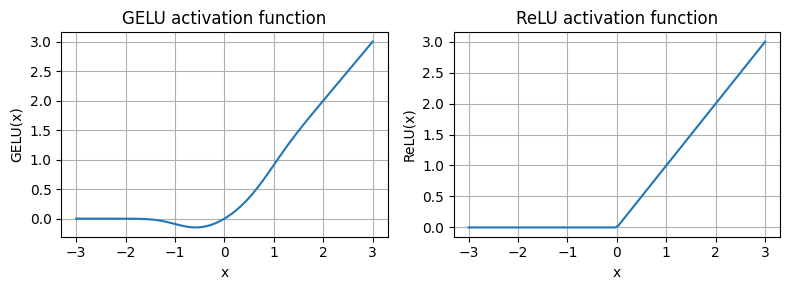

In [73]:
# Activation function
from models import GELU
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
from models import FeedForward

ffn = FeedForward(GPT_CONFIG_124M)

x = torch.rand(2, 3, 768)
out = ffn(x)
out

tensor([[[-1.8910e-02,  1.2931e-02, -2.2646e-01,  ..., -1.5223e-02,
          -1.8210e-03, -5.9271e-02],
         [-2.9184e-02, -5.5144e-02, -2.9393e-01,  ..., -9.9391e-06,
           4.3945e-02, -3.6865e-02],
         [-1.2955e-01,  2.8791e-02, -3.8951e-01,  ..., -6.3852e-02,
          -4.2675e-02,  1.5452e-02]],

        [[ 4.8324e-03,  8.7444e-02, -2.4740e-01,  ...,  3.6467e-02,
           6.4968e-02, -2.1661e-03],
         [-1.4453e-02,  3.2953e-03, -2.8413e-01,  ...,  6.6434e-02,
           1.1429e-02, -2.7560e-02],
         [-2.2525e-02, -3.8481e-02, -2.3742e-01,  ..., -1.1999e-01,
          -1.9021e-02,  5.4432e-02]]], grad_fn=<ViewBackward0>)

In [75]:
from models import ExampleDeepNeuralNetwork

layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([1. , 0., -1.])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([0.])

    loss = nn.MSELoss()

    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient of {param.grad.abs().mean().item()}")


print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient of 0.001531339017674327
layers.1.0.weight has gradient of 0.0008734675939194858
layers.2.0.weight has gradient of 0.0021116069983690977
layers.3.0.weight has gradient of 0.0030934528913348913
layers.4.0.weight has gradient of 0.007880646735429764


In [76]:
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient of 0.24866612255573273
layers.1.0.weight has gradient of 0.8006523847579956
layers.2.0.weight has gradient of 0.3836198151111603
layers.3.0.weight has gradient of 0.39542055130004883
layers.4.0.weight has gradient of 1.0010857582092285


In [77]:
from models import TransformerBlock

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


17. GPT class

In [78]:
from models import GPTModel, GPT_CONFIG_124M, GPT_CONFIG_MEDIUM, GPT_CONFIG_LARGE, GPT_CONFIG_XL

torch.manual_seed(123)
torch.set_printoptions(sci_mode=False)  # do not use scientific notation
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print(f"Input batch:\n{batch}")
print(f"Output batch:\n{out}")

Input batch:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output batch:
tensor([[[ 0.0967, -0.0039, -0.2247,  ..., -0.0418, -0.1078,  0.1488],
         [ 0.3412, -0.8254, -0.7412,  ..., -0.5463,  0.1970, -0.4303],
         [ 0.6882, -0.1170, -0.2338,  ...,  0.1141, -0.6860,  0.0646],
         [-0.3733,  0.2077, -0.1760,  ...,  1.1365,  0.4913, -0.5086]],

        [[ 0.0709, -0.2920, -0.1572,  ..., -0.0820,  0.2679, -0.2921],
         [ 0.0773, -0.2990, -0.3220,  ...,  1.1710,  0.0444,  0.1748],
         [ 0.7489,  0.5121, -0.4035,  ...,  0.7211,  0.2885, -0.2390],
         [-0.1525, -0.0339,  0.3752,  ...,  1.2968, -0.4658,  0.0257]]],
       grad_fn=<UnsafeViewBackward0>)


In [79]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total nubmber of parameters: {total_params:,}") # not 124M parameters because of weight tying. Original transformer was reusing weight from embedding layer in output layer 

Total nubmber of parameters: 163,009,536


In [80]:
print(f"Token embedding layer shape: {model.tok_emb.weight.shape}")
print(f"Output layer shape: {model.out_head.weight.shape}")

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [81]:
total_aprams_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())  # when we remove the count of paramters in output layer (50257*768=38597376) it is 124M parameters
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_aprams_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [82]:
total_params - 50257*768

124412160

In [83]:
sum(p.numel() for p in model.trf_blocks.parameters())

85026816

In [84]:
for i, block in enumerate(model.trf_blocks, start=1):
    print(f"Block: {i}, parameters in attn: {sum(p.numel() for p in block.attn.parameters()):,}")
    break

Block: 1, parameters in attn: 2,360,064


In [85]:
for i, block in enumerate(model.trf_blocks, start=1):
    print(f"Block: {i}, parameters in ffn: {sum(p.numel() for p in block.ff.parameters()):,}")
    break

Block: 1, parameters in ffn: 4,722,432


In [86]:
total_size_bytes = total_params * 4 # assuming float32, 4 bytes per parameter
total_size_mb = total_size_bytes / (1024*1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [87]:
# GPT_CONFIG_124M
# Number of trainable parameters considering weight tying: 124,412,160
# Block: 1, parameters in attn: 2,360,064
# Block: 1, parameters in ffn: 4,722,432
# Total size of the model: 621.83 MB

# GPT_CONFIG_MEDIUM
# Number of trainable parameters considering weight tying: 354,749,440
# Block: 1, parameters in attn: 4,195,328
# Block: 1, parameters in ffn: 8,393,728
# Total size of the model: 1549.58 MB

# GPT_CONFIG_LARGE
# Number of trainable parameters considering weight tying: 773,891,840
# Block: 1, parameters in attn: 6,554,880
# Block: 1, parameters in ffn: 13,113,600
# Total size of the model: 3197.56 MB

# GPT_CONFIG_XL
# Crashed RAM